In [140]:
using Plots
using Makie
using GraphMakie.NetworkLayout
using CairoMakie
using MPSKit
using TensorKit
using Tenet
using TensorOperations
using LinearAlgebra
using Graphs
using GraphPlot
using EinExprs
using Combinatorics
using LaTeXStrings
using FileIO
using JLD2
Makie.inline!(true)
include("julia_functions.jl")



generate_random_quantum_circuit (generic function with 1 method)

Definition of the relevant transformation functions in the notebook below:

Transform the full tensornetwork to the tree structure by sequentially applying the transformation defined in taken path

But first - redefinition of all the relevant functions

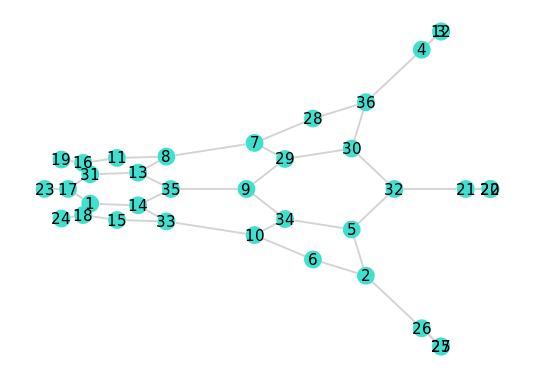

TN_tree_transform_approximate (generic function with 2 methods)

In [141]:

TN, graph, tv_map, ie_map, weighted_edge_list, ei_map = FileIO.load("transport variables/export_to_alphazero.jld2","A2")
taken_path = FileIO.load("transport variables/taken_path.jld2","taken_path")

# plot the graph structure of the initial graph
display(gplot(graph, nodelabel=[i for i in 1:nv(graph)], layout=spectral_layout))

function replace_index(tensor, replace_inds, new_inds)

    """
    Functionality which can take in a Tenet.Tensor and replace the list of 
    indices in replace_inds with the indices in new_inds:
    replace_inds[i] => new_inds[i]
    """

    mapping = Dict(zip(replace_inds, new_inds))
    current_inds = inds(tensor)
    ids = []
    for id in current_inds
        if id in replace_inds
            push!(ids, mapping[id])
        else
            push!(ids, id)
        end
    end
    new_tensor = Tenet.Tensor(tensor.data, [ids...])
    return new_tensor
end


function extract_partial_tn_loop(TN, index_cycle, printing = false)

    """
    Based on the index in the index cycle crop out a part of the tensor network
    and return this local LOOP-TensorNetwork.
    """
    println("Extraction index cycle = ", index_cycle)
    tensors_in_loop = collect(Set([tensor for id in index_cycle for tensor in Tenet.select(TN, [id])])) #correct orderding of variable definitions

    current_tn = TensorNetwork(tensor for tensor in tensors_in_loop)
    if printing == true
        drawing1 = Makie.plot(current_tn, node_color=[:darkred for i in 1:length(tensors(current_tn))], labels=true, layout=Stress(), edge_color=:grey80)
        display(drawing1)
    end
        
    return current_tn
end



function generate_unique_symbols()

    """
    Function which generates a list of new symbols for index replacing capability
    """
    new_symbols = [Symbol(i) for i in 1000:1500]
   
    return new_symbols
  
end


function create_index_isomorphismgroup(size_index1, size_index2, indices)
    n = size_index1*size_index2
    identity_data = Matrix{Int64}(I, n, n)
    tensor_isomorphism = reshape(identity_data, (size_index1, size_index2, n))
    identity_isomorphism = Tenet.Tensor(tensor_isomorphism, [(indices...)])
    return identity_isomorphism
end


function create_index_isomorphismsplit(propagation_size, cut_size, new_indices, propagation_index)
    size_id_to_tensor = convert(Int64, propagation_size/cut_size)
    size_loop_part = cut_size
    n = propagation_size
    identity_data = Matrix{Int64}(I, n, n)
    tensor_isomorphism = reshape(identity_data, (propagation_size, size_id_to_tensor, size_loop_part))
    identity_isomorphism = Tenet.Tensor(tensor_isomorphism, [propagation_index, new_indices...])
    return identity_isomorphism
end

function collect_tensors_along_loop(loop_tn, index_cycle, index_to_cut)

    """
    Funtion whcih sequentially walks along the index cycle in the correct order
    loop and selects the relevant tensors.
    Return a list of tensors which is correctly ordered along the loop.
    """
    println("index_cycle = ", index_cycle)
    println("index_to_cut = ", index_to_cut)
    global start_tensor
    global end_tensor

    connectedtensors = Tenet.select(loop_tn, index_to_cut)
    firstsymbol = index_cycle[1]
    for tensor in connectedtensors
        if !isempty(intersect(inds(tensor), [firstsymbol]))
            global start_tensor = tensor
        else
            global end_tensor = tensor
        end
    end

    tensors_ordered_loop = []
    for i in 1:length(tensors(loop_tn))
        if i == length(tensors(loop_tn))
            push!(tensors_ordered_loop, end_tensor)
            return tensors_ordered_loop
        end
        if i == 1
            push!(tensors_ordered_loop, start_tensor)
            continue
        end
        connecting_id = intersect(inds(tensors_ordered_loop[i-1]), [Symbol(id) for id in index_cycle])
        next_tensor = [tensorc for tensorc in Tenet.select(loop_tn, connecting_id)  if tensorc != tensors_ordered_loop[i-1]][1]
        index_cycle = filter(x -> x != connecting_id[1], index_cycle)
        push!(tensors_ordered_loop, next_tensor)
    end
    
    return tensors_ordered_loop
end


function new_node_cycle(node_cycle::Vector{Int}, edge_to_cut::Tuple{Int, Int})

    """
    Put the node cycle in the correct ordering which places the node cycle
    in the correct form the extract the MPS.
    """
    
    for i in 1:length(node_cycle)
        node_perm = circshift( node_cycle, i-1)
        first_index = findfirst(x -> x == edge_to_cut[1], node_perm)
        second_index = findfirst(x -> x == edge_to_cut[2], node_perm)
        if sort([first_index, second_index]) == [1, length(node_cycle)]
            node_cycle = node_perm
            break
        end
    end
    return node_cycle
end



function compress_Tenet_MPS(TenetMPS, physical_order, inds_connecting, chi_max, printing = false)

    """
    Function which takes in a TenetMPS, a order of the physical indices,
    and a max allowable chi_max. Compresses the MPS using a conversion to MPSKit
    and DMRG compression. After compression reconverts to TenetMPS and returns
    the compressed MPS.
    """
    
    physical_order = [id for id in physical_order]
    
    """
    Contract these the edge nodes to form a MPSKit compatible MPS.
    """

    tv1 = Tenet.select(TenetMPS, [physical_order[1]])[1]
    tv2 = Tenet.select(TenetMPS, [physical_order[end]])[1]

    v1 = setdiff(inds(tv1), [physical_order[1]])[1]
    v2 = setdiff(inds(tv2), [physical_order[end]])[1]
    println(v1, v2)
    contraction_step(TenetMPS, v1)
    contraction_step(TenetMPS, v2)

    if length(Tenet.tensors(TenetMPS)) == 1
        println("loop reduced to one tensor")
        return TenetMPS
    end
   
    
    global ids 

    T_ordered = []
    inds_connection = []
    left_index = physical_order[1]
    for i in 1:length(Tenet.tensors(TenetMPS))
        if i == 1
            for t in Tenet.tensors(TenetMPS)
                ids = inds(t)
                if !isempty(intersect(inds(t), [left_index]))
                    push!(T_ordered, t)
                    break
                end
            end
        end
        for t in Tenet.tensors(TenetMPS)
            if t ∉ T_ordered
                if !isempty(intersect(inds(t), ids))
                    push!(inds_connection, intersect(inds(t), ids)[1])

                    push!(T_ordered, t)
                    ids = inds(t)
                end
            end
        end
    end
    
    inds_connection = [id for id in inds_connection]
    pushfirst!(inds_connection, v1)
    push!(inds_connection, v2)

    #TODO: is this correct? no

    first = [physical_order[1], physical_order[2], inds_connection[2]]
    last = [inds_connection[end-1], physical_order[end-1], physical_order[end]]
   
    permutation_list = []
    for i in 3:length(physical_order)-2
        push!(permutation_list, [inds_connection[i-1], physical_order[i], inds_connection[i]])
    end

    pushfirst!(permutation_list, first)
    push!(permutation_list, last)

    extracted_maps = []
    approximate_extracted_maps = []
    approximate_sizes_list = []

    """
    Extract the TensorKit Maps
    """

    for (i, t) in enumerate(T_ordered)
        t = permutedims(t, permutation_list[i])
        push!(extracted_maps, TensorMap(t.data, ℂ^(size(t, inds(t)[1])) ⊗ ℂ^(size(t, inds(t)[2])), ℂ^(size(t, inds(t)[3]))))

        # Always keep the correct physical size
        # Keep the bond dimension to the chi_max value or smaller
        # take min(chi_max, needed dim) in the virtual connecting spaces
        
        
        push!(approximate_extracted_maps, TensorMap(rand(ComplexF64, minimum([chi_max, size(t, inds(t)[1])]), 
                                                                    (size(t, inds(t)[2])), 
                                                                    minimum([chi_max, size(t, inds(t)[3])])),
                                                                    ℂ^minimum([chi_max, size(t, inds(t)[1])]) ⊗ ℂ^(size(t, inds(t)[2])),
                                                                     ℂ^minimum([chi_max, size(t, inds(t)[3])])))
        push!(approximate_sizes_list, (minimum([chi_max, size(t, inds(t)[1])]), (size(t, inds(t)[2])), minimum([chi_max, size(t, inds(t)[3])])))
    end

    extracted_maps = [map for map in extracted_maps]
    approximate_extracted_maps = [map for map in approximate_extracted_maps]
    
    mps_exact = FiniteMPS(extracted_maps)
    mps_approximate = FiniteMPS(approximate_extracted_maps)
    
    if printing == true 
        println("Exact MPS = \n" , mps_exact)
        println("Approximate MPS = \n" , mps_approximate)
    end

    """
    Run the compression algorithm 
    """

    # Create a DMRG algorithm instance
    alg = DMRG(;  # Choose DMRG (1-site) for this example
            maxiter = 40,  # Maximum number of iterations
            verbose = false,   # Verbosity level (0: silent, 1: basic, 2: detailed)
            tol = 1e-16
            )
    
    I_MPO = DenseMPO([MPSKit.add_util_leg(id(storagetype(MPSKit.site_type(mps_exact)), physicalspace(mps_exact, i))) for i in 1:length(mps_exact)]) # corresponding identity operator as an MPO
    mps_new, = approximate(mps_approximate, (I_MPO, mps_exact), alg)
       

    """
    Reconvert to Tenet.TensorNetwork compatible format
    """

    new_tenet_tensors = []
    for i in 1:length(mps_new)
        if i == length(mps_new)
            shaped_data = reshape(mps_new.AC[i].data, (approximate_sizes_list[i]))
            new_t = Tenet.Tensor(shaped_data, permutation_list[i])
            push!(new_tenet_tensors, new_t)
            break
        end

        shaped_data = reshape(mps_new.AL[i].data, (approximate_sizes_list[i]))
        new_t = Tenet.Tensor(shaped_data, permutation_list[i])
        push!(new_tenet_tensors, new_t)
    end

    TenetMPS = Tenet.TensorNetwork(new_tenet_tensors)

    
    return TenetMPS

end


function loop_and_QRED_mps_overlap(loop, physical_index_ordering, index_cycle, chi_max, printing = false, plotting = false)
    inds_connection = index_cycle
    """ 
    define original loop and use it to compute a QRED => MPS
    => return the mps tensor network and provide a local fidelity analysis
    """ 

    loop_net = deepcopy(loop)
    if plotting == true
        drawing1 = Makie.plot(loop_net, node_color=[:darkred for i in 1:length(tensors(loop_net))], labels=true, layout=Stress(), edge_color=:grey80)
        display(drawing1)
    end

    virtual = [Symbol("v$i") for i in 1:100] 
    contracted_loop = Tenet.contract(loop_net)
    global prop_id

    """
    Transform the loop TensorNetwork into an exact MPS tensor
    """

    T_QR1 = []
    R = contracted_loop
    connection_indices = virtual[1:length(inds(R))-1]
    for (i, index) in enumerate(physical_index_ordering)
        if i == length(physical_index_ordering)
            push!(T_QR1, R)
            break
        end
        if i == 1
            Q, R = LinearAlgebra.qr(R, left_inds=[index], virtualind=virtual[i])
            push!(T_QR1, Q)
            global prop_id = setdiff(inds(Q), [index])[1]
        end
        if i > 1
            Q, R = LinearAlgebra.qr(R, left_inds=[index, prop_id], virtualind=virtual[i])
            push!(T_QR1, Q)
            prop_id = setdiff(inds(Q), [index, prop_id])[1]
        end
    end

    # define tensor networks 
    loop_net = deepcopy(loop)
    mps_net = Tenet.TensorNetwork(T_QR1)


    """
    Convert TenetMPS to MPSKit MPS --> Apply approximation function
    """

    println("conn")
    mps_net = compress_Tenet_MPS(mps_net, physical_index_ordering, inds_connection, chi_max, true)
    tens_tnet = vcat(Tenet.tensors(loop_net), Tenet.tensors(mps_net))
    t_net_full = Tenet.TensorNetwork(tens_tnet)
    contracted_loop = (Tenet.contract(loop_net))
    contracted_Qr = (Tenet.contract(mps_net))
    
    if plotting == true
        drawing1 = Makie.plot(t_net_full, node_color=[:darkred for i in 1:length(tensors(t_net_full))], labels=true, layout=Stress(), edge_color=:grey80)
        display(drawing1)
    end

    """
    FIDELITY ANALYSIS
    """

    overlap_looploop = abs((Tenet.contract(contracted_loop, contracted_loop))[1])
    overlap_QrQr = abs((Tenet.contract(contracted_Qr, contracted_Qr))[1])
    overlap_full = abs((Tenet.contract(t_net_full))[1])
    if printing == true
        println(" ---------------- Local fidelity analysis ----------------- ")
        println("Error = |1- |< loop | mps >|^2 /(|< loop | loop >||< mps | mps >|)|  = ", abs(1- overlap_full^2/(overlap_looploop*overlap_QrQr)))
    end

    F =  overlap_full^2/(overlap_looploop*overlap_QrQr)

    return F, mps_net, connection_indices
end


function LOOP_TO_APPROXIMATE_MPS(loop_tn, index_cycle, index_to_cut, chi_max, plotting = false, printing = false)

    """ 
    Function takes in the original loop tensor network and transform this to
    a partly contracted MPS tensor, which is approximated to chi_max.
    """
    
    # STEP 1: FORM LOOP TN => TRANSFORMABLE TO MPS

    """
    Take care of the case where no dangling edges are found: 
    => prematurely contract these tensors onto each other
    Create a MPS compatible loop TN 
    """

    fullcycle = deepcopy(index_cycle)

    if plotting == true
        drawing1 = Makie.plot(loop_tn, node_color=[:darkred for i in 1:length(Tenet.tensors(loop_tn))], labels=true, layout=Stress(), edge_color=:grey80)
        display(drawing1)
    end

    println("loop_tn = ", loop_tn)

    for t in Tenet.tensors(loop_tn)
        if length(inds(t)) == 2
            println("contracted...")
            # filter it out of the index cycle

            filter!(x -> x != inds(t)[1], index_cycle)
            if index_to_cut == [inds(t)[1]]
                println("contracted the cut index -> moving the boundary")
                index_to_cut = [inds(t)[2]]
            end
            # contraction step --> contract the non-dangling part
            contraction_step(loop_tn, [inds(t)[1]])
           
        end
    end

    println("loop_tn = ", loop_tn)

    # STEP 1.1 -- EXTRACT RELEVANT DATA BEFORE TRANSFORMING 

    """
    collect tensors along the loop from start_tensor to end_tensor
    and reorganize_cycle for correct ordering along the loop
    """
        
    for (idx, index) in enumerate(index_cycle)
        if index == index_to_cut[1]
            index_cycle = vcat(index_cycle[idx+1:end], index_cycle[1:idx-1])
            break
        end
    end

    ordered_along_loop = collect_tensors_along_loop(loop_tn, deepcopy(index_cycle), index_to_cut)
    inds_connection = index_cycle

    physical_index_ordering = []
    for t in ordered_along_loop
        push!(physical_index_ordering, setdiff(inds(t), fullcycle)[1])
    end
    physical_index_ordering = [id for id in physical_index_ordering]

    """
    Extract the physical_index_ordering from the loop which allow the to create
    the correct MPS-structure based on the local LOOP-TensorNetwork.
    """

    

    # STEP 2: FORM EXACT MPS

    """ 
    define original loop and use it to compute a QRED => MPS
    => return the mps tensor network and provide a local fidelity analysis
    """ 

    loop_net = deepcopy(loop_tn)
    if plotting == true
        drawing1 = Makie.plot(loop_net, node_color=[:darkred for i in 1:length(tensors(loop_net))], labels=true, layout=Stress(), edge_color=:grey80)
        display(drawing1)
    end

    virtual = [Symbol("v$i") for i in 1:100] 
    contracted_loop = Tenet.contract(loop_net)
    global prop_id

    """
    Transform the loop TensorNetwork into an exact MPS tensor
    """

    T_QR1 = []
    R = contracted_loop
    connection_indices = virtual[1:length(inds(R))-1]
    for (i, index) in enumerate(physical_index_ordering)
        if i == length(physical_index_ordering)
            push!(T_QR1, R)
            break
        end
        if i == 1
            Q, R = LinearAlgebra.qr(R, left_inds=[index], virtualind=virtual[i])
            push!(T_QR1, Q)
            global prop_id = setdiff(inds(Q), [index])[1]
        end
        if i > 1
            Q, R = LinearAlgebra.qr(R, left_inds=[index, prop_id], virtualind=virtual[i])
            push!(T_QR1, Q)
            prop_id = setdiff(inds(Q), [index, prop_id])[1]
        end
    end

    # define tensor networks 
    loop_net = deepcopy(loop_tn)
    mps_net = Tenet.TensorNetwork(T_QR1)

    """
    Convert TenetMPS to MPSKit MPS --> Apply approximation function
    """
    mps_net = compress_Tenet_MPS(mps_net, physical_index_ordering, inds_connection, chi_max, false)

    """
    Based on the approximated MPS - perform an analysis
    """

    tens_tnet = vcat(Tenet.tensors(loop_net), Tenet.tensors(mps_net))
    t_net_full = Tenet.TensorNetwork(tens_tnet)
    contracted_loop = (Tenet.contract(loop_net))
    contracted_Qr = (Tenet.contract(mps_net))
    
    """
    FIDELITY ANALYSIS
    """

    overlap_looploop = abs((Tenet.contract(contracted_loop, contracted_loop))[1])
    overlap_QrQr = abs((Tenet.contract(contracted_Qr, contracted_Qr))[1])
    overlap_full = abs((Tenet.contract(t_net_full))[1])
    if printing == true
        println(" ---------------- Local fidelity analysis ----------------- ")
        println("Error = |1- |< loop | mps >|^2 /(|< loop | loop >||< mps | mps >|)|  = ", abs(1- overlap_full^2/(overlap_looploop*overlap_QrQr)))
    end

    """
    replace the virtual indices in the MPS with the correct cycle indices
    old => new
    """

    connection_indices = connection_indices[2:end-1]
    for i in 1:length(connection_indices)
        c1 = connection_indices[i]
        i1 = index_cycle[i]
        println("Connection $c1 => $i1")
        replace!(mps_net, connection_indices[i] => index_cycle[i])
    end

    return mps_net
end

function transform_to_MPS_QR_approximate(TN, edge_to_cut, node_cycle, chi_max, printing = false)

    """
    Function which takes in full tensor network, a cycle of tensor nodes
    and an edge to cut (tuple of two nodes).
    Returns the transformed TensorNetwork, were the loop defined by the cycle
    of nodes is replaced by the contracted MPS like structure.
    """

    # 1. TRANSFORM NODE CYCLE TO EDGE CYCLE

    cycle = new_node_cycle(node_cycle, edge_to_cut)
    edge_cycle = []
    # extract the edges from the current node cycle to check dictionary availability
    c_edges = [[cycle[i], cycle[i+1]] for i in 1:length(cycle)-1]
    push!(c_edges, [cycle[end], cycle[1]])
    for edge in c_edges
        push!(edge_cycle, Tuple(sort(edge)))
    end

    # 2. TRANSFORM EDGE CYCLE TO INDEX CYCLE
    indices = [ei_map[edge] for edge in edge_cycle]
    index_cycle = [index[1] for index in indices]
    fullcycle = deepcopy(index_cycle)
    index_to_cut = ei_map[edge_to_cut]
    # 3. EXTRACT THE LOOP NETWORK BASED ON THE INDEX CYCLE 

    loop_tn = extract_partial_tn_loop(TN, index_cycle, false)
    loop_indices = inds(loop_tn)
    old_loop = deepcopy(loop_tn)

    mps_network = LOOP_TO_APPROXIMATE_MPS(loop_tn, index_cycle, index_to_cut, chi_max, false, false)
    
    # 4. MODIFY THE TN: pop! the LOOP and push! the MPS
    for id in fullcycle[1:end-1]
        # last one is already removed
        tens = Tenet.select(TN, id)
        for t in tens
            pop!(TN, t)
        end
    end

    for tensor in Tenet.tensors(mps_network)
        push!(TN, tensor)
    end

    return TN
end

function TN_tree_transform_approximate(TN, chi_max, plotting_final = false)

    """
    Function which takes in the TensorNetwork which contains_loops and a
    taken_path from the AlphaZero agent.
    Performs the deloopification by inserting exact MPS tree representations.
    """

    if plotting_final == true
        drawing1 = Makie.plot(TN, node_color=[:darkred for i in 1:length(tensors(TN))], layout=Stress(), edge_color=:grey80)
        display(drawing1)
    end

    println("contracting initial network.....")

    with_loops = deepcopy(TN)

    path_loops = einexpr(with_loops, optimizer = Greedy())
    println("cost = ", mapreduce(flops, +, Branches(path_loops)))
    path = Makie.plot(path_loops)
    
    display(path)
    time_loop = @elapsed begin   
        T_loop = Tenet.contract(with_loops)
    end

    """
    Walk the action path and apply each action sequentially on the 
    LOOP-TensorNetwork. Replace the loop with the tree.
    """

    global g
    global tv_map
    global ie_map
    global ei_map

    g, tv_map, ie_map, edge_weighed_list, ei_map = extract_graph_representation(TN)

    while is_tree(g) == false
        cycle_basis = minimum_cycle_basis(g)
        println("amount of loops in the network = ", length(cycle_basis))
        println(cycle_basis)
        node_cycle = cycle_basis[1]
        edge_to_cut = Tuple(sort([node_cycle[1], node_cycle[2]]))
        TN = transform_to_MPS_QR_approximate(TN, edge_to_cut, node_cycle, chi_max)
        g, tv_map, ie_map, edge_weighed_list, ei_map = extract_graph_representation(TN)
    end

    println("TN is transformed to a tree")
    if plotting_final == true
        drawing1 = Makie.plot(TN, node_color=[:darkred for i in 1:length(tensors(TN))], layout=Stress(), edge_color=:grey80)
        display(drawing1)
    end

    println("contracting tree-i-fied network.....")

    """
    Calculating the overlaps and fidelities.
    """

    tree = deepcopy(TN)
    time_tree = @elapsed begin
        T_tree = Tenet.contract(TN)
    end

    path_tree = einexpr(tree)
    println("cost = ", mapreduce(flops, +, Branches(path_loops)))

    println("cost = ", mapreduce(flops, +, Branches(path_tree)))
    path = Makie.plot(path_tree)
    display(path)
   
    println("contraction_time with loops = ", time_loop, "[s]")
    println("contraction_time tree = ", time_tree, "[s]")


    overlap_looploop = abs((Tenet.contract(T_loop, T_loop))[1])
    overlap_treetree = abs((Tenet.contract(T_tree, T_tree))[1])
    overlap_full = abs((Tenet.contract(T_tree, T_loop))[1])

    println(" ---------------- GLOBAL FIDELITY ANALYSIS ------------ ")
    println("< Loop - state | Loop - state > = ", overlap_looploop)
    println("< Tree - state | Tree - state > = ", overlap_treetree)
    println("< Loop - state| Tree - state > = ", overlap_full)
    println("|1- |< Loop- state | Tree - state >|^2 /(|< Loop - state | Loop - state >||< Tree - state | Tree - state >|)|  = ", abs(1-overlap_full^2/(overlap_looploop*overlap_treetree)))

    return TN
end






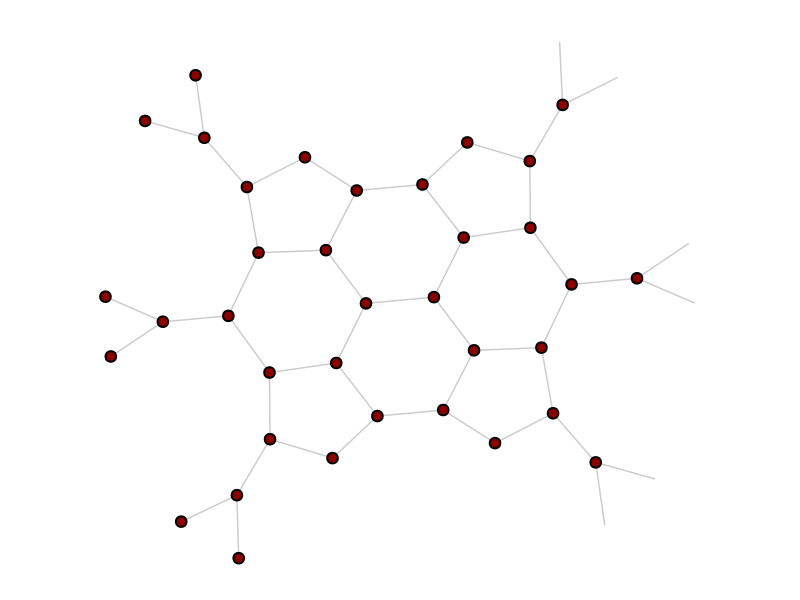

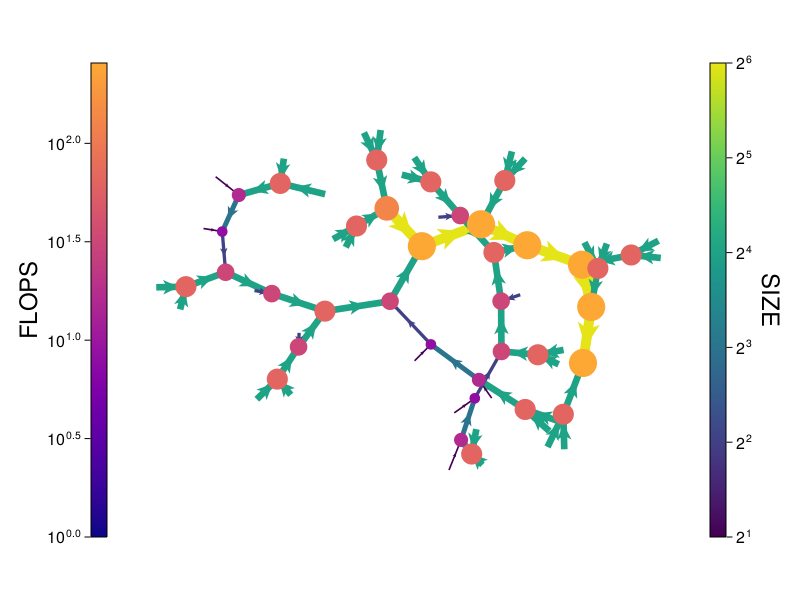

contracting initial network.....
cost = 2920
amount of loops in the network = 8
Any[[14, 33, 15, 18, 1], [8, 11, 16, 31, 13], [29, 30, 36, 28, 7], [6, 2, 5, 34, 10], [14, 35, 9, 34, 10, 33], [29, 7, 8, 13, 35, 9], [13, 31, 17, 1, 14, 35], [29, 9, 34, 5, 32, 30]]
Extraction index cycle = [Symbol("24"), Symbol("30"), Symbol("29"), Symbol("01cac46b-fc11-4d2e-9f4c-1b9413cdb9c9"), Symbol("23")]
loop_tn = TensorNetwork(#tensors=5, #inds=9)
contracted...
loop_tn = TensorNetwork(#tensors=4, #inds=8)
index_cycle = [Symbol("30"), Symbol("29"), Symbol("01cac46b-fc11-4d2e-9f4c-1b9413cdb9c9")]
index_to_cut = [Symbol("23")]
v1v3
Connection v2 => 30
amount of loops in the network = 7
Any[[4, 31, 9, 5, 1], [12, 28, 14, 18, 32], [12, 7, 10, 13, 28], [26, 27, 33, 25, 6], [30, 18, 32, 8, 31, 9], [26, 8, 31, 4, 29, 27], [8, 26, 6, 7, 12, 32]]
Extraction index cycle = [Symbol("17"), Symbol("18"), Symbol("12"), Symbol("11"), Symbol("c2150c02-e598-407e-a216-97a0408bdf40")]
loop_tn = TensorNetwork(#tensors=5,

┌ Warning: dmrg failed to converge 9.563100906154576e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78
┌ Warning: dmrg failed to converge 8.3922164824676e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


Connection v2 => 22
Connection v3 => 30
amount of loops in the network = 5
Any[[8, 26, 12, 9], [24, 16, 5, 27, 25], [8, 4, 6, 11, 26], [23, 28, 25, 24, 3], [4, 8, 9, 10, 16, 24, 3]]
Extraction index cycle = [Symbol("27"), Symbol("28"), Symbol("21"), Symbol("991a6bf0-7285-44f8-a258-97e7be1e3e78")]
loop_tn = TensorNetwork(#tensors=4, #inds=8)
loop_tn = TensorNetwork(#tensors=4, #inds=8)
index_cycle = [Symbol("27"), Symbol("28"), Symbol("21")]
index_to_cut = [Symbol("991a6bf0-7285-44f8-a258-97e7be1e3e78")]
v1v3
Connection v2 => 27
amount of loops in the network = 4
Any[[23, 15, 5, 25, 24], [4, 6, 9, 10, 11], [22, 26, 24, 23, 3], [23, 3, 4, 11, 8, 15]]
Extraction index cycle = [Symbol("17"), Symbol("10"), Symbol("9"), Symbol("7eec33ae-ff5d-4fe4-9ec3-1183124665ef"), Symbol("15")]
loop_tn = TensorNetwork(#tensors=5, #inds=10)
loop_tn = TensorNetwork(#tensors=5, #inds=10)
index_cycle = [Symbol("17"), Symbol("10"), Symbol("9"), Symbol("7eec33ae-ff5d-4fe4-9ec3-1183124665ef")]
index_to_cut = [Sy

┌ Warning: dmrg failed to converge 9.118012627648357e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78
┌ Warning: dmrg failed to converge 7.964829871873524e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


Connection v2 => 17
Connection v3 => 10
amount of loops in the network = 3
Any[[3, 4, 23, 24], [7, 10, 11, 12, 5], [3, 6, 16, 9, 12, 5, 4]]
Extraction index cycle = [Symbol("13"), Symbol("7"), Symbol("8"), Symbol("14")]
loop_tn = TensorNetwork(#tensors=4, #inds=7)
contracted...
loop_tn = TensorNetwork(#tensors=3, #inds=6)
index_cycle = [Symbol("13"), Symbol("8")]
index_to_cut = [Symbol("14")]
v1v2
loop reduced to one tensor
amount of loops in the network = 2
Any[[4, 6, 9, 10, 11], [4, 11, 8, 15, 5, 3]]
Extraction index cycle = [Symbol("25"), Symbol("26"), Symbol("27"), Symbol("20"), Symbol("19")]
loop_tn = TensorNetwork(#tensors=5, #inds=9)
contracted...
contracted the cut index -> moving the boundary
loop_tn = TensorNetwork(#tensors=4, #inds=8)
index_cycle = [Symbol("26"), Symbol("27"), Symbol("20")]
index_to_cut = [Symbol("25")]
v1v3
Connection v2 => 26
amount of loops in the network = 1
Any[[4, 12, 6, 7, 3]]
Extraction index cycle = [Symbol("30"), Symbol("22"), Symbol("13e20c92-7e38

┌ Warning: dmrg failed to converge 7.792992239173026e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78
┌ Warning: dmrg failed to converge 1.0046658846299358e-15>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


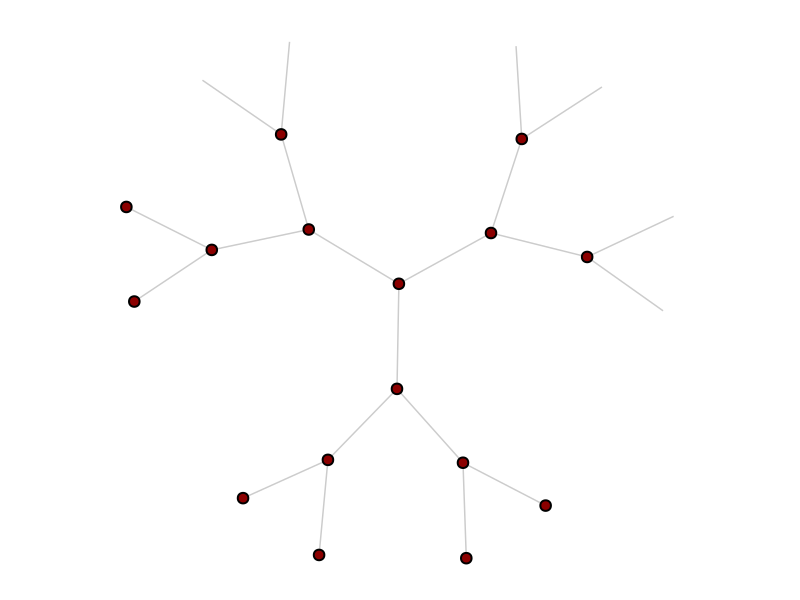

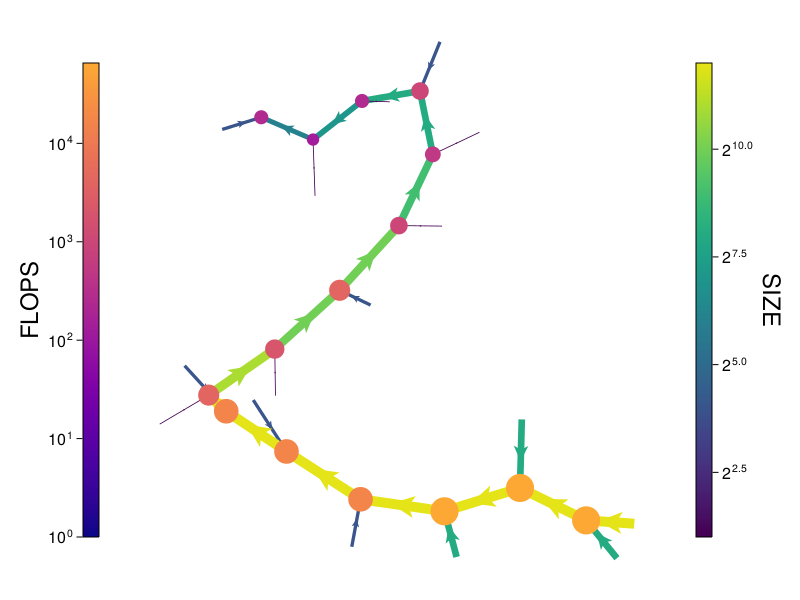

Connection v2 => 30
Connection v3 => 22
TN is transformed to a tree
contracting tree-i-fied network.....
cost = 2920
cost = 259200


┌ Warning: dmrg failed to converge 8.194749723056286e-16>1.0e-16
└ @ MPSKit /home/bart/.julia/packages/MPSKit/atykv/src/algorithms/approximate/fvomps.jl:78


contraction_time with loops = 0.004723083[s]
contraction_time tree = 0.003779893[s]
 ---------------- GLOBAL FIDELITY ANALYSIS ------------ 
< Loop - state | Loop - state > = 0.17059329612093752
< Tree - state | Tree - state > = 0.17059329612093732
< Loop - state| Tree - state > = 0.1705932961209374
|1- |< Loop- state | Tree - state >|^2 /(|< Loop - state | Loop - state >||< Tree - state | Tree - state >|)|  = 1.1102230246251565e-16


TensorNetwork(#tensors=16, #inds=21)

In [142]:
# Run this to approximately contract a LOOP_TN using small MPS based on smallest loops

TN_tree_transform_approximate(TN, 16, true)

Now a function to transform a TENET MPS -> MPSKit MPS -> Approximate MPSKit MPS -> Approximate Tenet MPS